In [138]:
# Lib imports
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers  # Add at the top with imports
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

In [139]:
# DATASET DIRECTORY CONFIGURATION
# Download and unzip the dataset from Kaggle, set the directory paths accordingly.
train_dir = "muffin-vs-chihuahua/train_1"  # e.g. './muffin-vs-chihuahua/train'
test_dir = "muffin-vs-chihuahua/test_1"    # e.g. './muffin-vs-chihuahua/test'

In [140]:
# IMAGE PARAMETERS
# Used to resize the input images, also will determine the input size of your input layer.
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [141]:
# DATA PREPROCESSING & AUGMENTATION
# Optional but recommended for image processing tasks, especially with limited data.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['muffin', 'chihuahua'], # correct label ordering
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['muffin', 'chihuahua'],
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['muffin', 'chihuahua'],
    shuffle=False
)

Found 3788 images belonging to 2 classes.
Found 945 images belonging to 2 classes.
Found 1186 images belonging to 2 classes.


In [143]:
# SIMPLE CNN MODEL ARCHITECTURE

# Some modifications are applied
initial_learning_rate = 0.0008
# We are combining ExponentialDecay with Adam optimizer for better learning rate management
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

# Create the optimizer with the learning rate schedule
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

# Applied dropout layers to reduce overfitting
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

In [144]:
# Configure the model optimizers, loss function, and metrics
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # old
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [145]:
# TRAINING THE CNN

early_stop = EarlyStopping(
    monitor='val_loss',  # watch the validation loss
    patience=5,          # stop if no improvement for 5 epochs
    restore_best_weights=True  # restore weights from the best epoch
)

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stop]  # add the callback here
)

Epoch 1/25
119/119 [==============================] - 80s 650ms/step - loss: 1.3541 - accuracy: 0.7376 - val_loss: 13.9792 - val_accuracy: 0.5407
Epoch 2/25
119/119 [==============================] - 84s 708ms/step - loss: 0.8893 - accuracy: 0.7933 - val_loss: 6.7040 - val_accuracy: 0.5407
Epoch 3/25
119/119 [==============================] - 101s 847ms/step - loss: 0.8098 - accuracy: 0.8247 - val_loss: 1.6639 - val_accuracy: 0.5630
Epoch 4/25
119/119 [==============================] - 104s 871ms/step - loss: 0.7524 - accuracy: 0.8363 - val_loss: 1.8958 - val_accuracy: 0.5862
Epoch 5/25
119/119 [==============================] - 105s 879ms/step - loss: 0.6920 - accuracy: 0.8530 - val_loss: 2.0213 - val_accuracy: 0.5958
Epoch 6/25
119/119 [==============================] - 118s 993ms/step - loss: 0.6942 - accuracy: 0.8593 - val_loss: 1.2777 - val_accuracy: 0.7026
Epoch 7/25
119/119 [==============================] - 91s 761ms/step - loss: 0.7019 - accuracy: 0.8582 - val_loss: 1.8557 - v

In [146]:
# EVALUATE THE MODEL
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

38/38 [==============================] - 9s 231ms/step - loss: 0.6016 - accuracy: 0.8600
Test Accuracy: 0.8600337505340576


In [154]:
# SAVE THE MODEL
model.save('exercise_6_trained_model_improved.h5')

In [88]:
# # SIMPLE INFERENCE SCRIPT
# from tensorflow.keras.preprocessing import image

# def predict_image(img_path, model_path='muffin_vs_chihuahua_cnn.h5'):
#     model = tf.keras.models.load_model(model_path)
#     img = image.load_img(img_path, target_size=IMG_SIZE)
#     img_array = image.img_to_array(img) / 255.0
#     img_array = np.expand_dims(img_array, axis=0)
#     pred = model.predict(img_array)[0,0]
#     label = "Chihuahua" if pred >= 0.5 else "Muffin"
#     print(f"Prediction: {label} (confidence: {pred:.2f})")


In [155]:
def predict_image(img_path, model_path='exercise_6_trained_model_improved.h5'):
    # Load model
    model = tf.keras.models.load_model(model_path)
    
    # Load and preprocess image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array_exp = np.expand_dims(img_array, axis=0)
    
    # Predict
    pred = model.predict(img_array_exp)[0,0]
    label = "Chihuahua" if pred >= 0.5 else "Muffin"
    
    # Display the image
    # plt.imshow(img)
    # plt.axis('off')
    # plt.title(f"Prediction: {label}\nConfidence: {pred:.2f}")
    # plt.show()
    plt.imshow(img)
    plt.title(f"Prediction: {label}\nConfidence: {pred:.2f}")
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 452ms/step


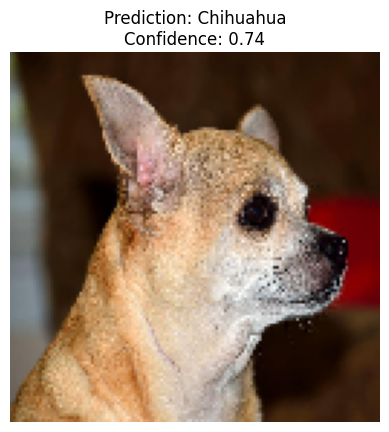

1/1 [==============================] - 1s 540ms/step


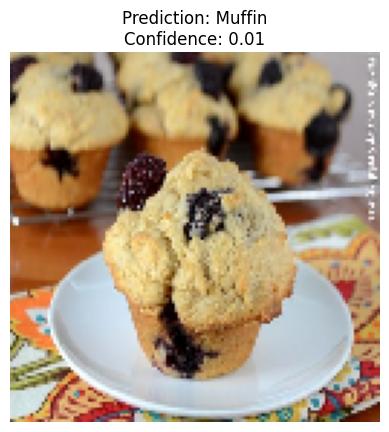

In [156]:
# # Example usage:
# predict_image("muffin-vs-chihuahua/test_1/chihuahua/img_4_226.jpg")
# predict_image("muffin-vs-chihuahua/test_1/muffin/img_3_711.jpg")

# Run 1
predict_image("muffin-vs-chihuahua/test_1/chihuahua/img_0_1107.jpg",
              model_path='exercise_6_trained_model_improved.h5')
# Run 2
predict_image("muffin-vs-chihuahua/test_1/muffin/img_1_60.jpg",
              model_path='exercise_6_trained_model_improved.h5')